In [5]:
import mle_logging
import matplotlib.pyplot as plt
import pickle
import os
from natsort import natsorted
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import tqdm


from torch.utils.data import DataLoader
from torch.optim import lr_scheduler, Adam
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
device_list = ['3080Ti', 'RTXA4000', 'V100']
seed_list = ['1234', '3407', '3483', '4538', '9899']


In [29]:
checkpoint_root = './checkpoint_files'

l1_norm_dict = {}
for i in range(len(device_list)):
    for j in range(i+1, len(device_list)):
        for o in range(len(seed_list)):
            #print(f'Folder One: {checkpoint_root}/{device_list[i]}/{seed_list[o]}')
            #print(f'Folder Two: {checkpoint_root}/{device_list[j]}/{seed_list[o]}')
            #print('****')
            device_one_path = f'{checkpoint_root}/{device_list[i]}/{seed_list[o]}'
            device_two_path = f'{checkpoint_root}/{device_list[i]}/{seed_list[o]}'
            l1_norms = []
            print(f'Working on DEVICE1: {device_list[i]} DEVICE2: {device_list[j]} SEED: {seed_list[o]}')
            start_time = time.time()
            for ckpt1, ckpt2 in zip(natsorted(os.listdir(device_one_path)), natsorted(os.listdir(device_two_path))):
                if not (ckpt1.startswith('.') or ckpt2.startswith('.')):
                    model1 = torchvision.models.resnet18(pretrained=False)
                    model1.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    model1.maxpool = nn.Identity()
                    model1.fc = nn.Linear(model1.fc.in_features, 10)
                    
                    model2 = torchvision.models.resnet18(pretrained=False)
                    model2.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    model2.maxpool = nn.Identity()
                    model2.fc = nn.Linear(model1.fc.in_features, 10)

                    model1.load_state_dict(torch.load(os.path.join(device_one_path, ckpt1), map_location='cpu'))
                    model2.load_state_dict(torch.load(os.path.join(device_two_path, ckpt2), map_location='cpu'))

                    model1_params = torch.nn.utils.parameters_to_vector(model1.parameters())
                    model2_params = torch.nn.utils.parameters_to_vector(model2.parameters())

                    l1_norm = torch.norm(model1_params - model2_params, p=1)

                    l1_norms.append(l1_norm.detach().item())
            end_time = time.time()
            print(f'One loop took {end_time - start_time}')
            l1_norm_dict[f'DEVICE1: {device_list[i]} DEVICE2: {device_list[j]} SEED: {seed_list[o]}'] = l1_norms

Working on DEVICE1: 3080Ti DEVICE2: RTXA4000 SEED: 1234
One loop took 10.148749113082886
Working on DEVICE1: 3080Ti DEVICE2: RTXA4000 SEED: 3407
One loop took 10.066551208496094
Working on DEVICE1: 3080Ti DEVICE2: RTXA4000 SEED: 3483
One loop took 10.067546844482422
Working on DEVICE1: 3080Ti DEVICE2: RTXA4000 SEED: 4538
One loop took 9.975295066833496
Working on DEVICE1: 3080Ti DEVICE2: RTXA4000 SEED: 9899
One loop took 10.024126052856445
Working on DEVICE1: 3080Ti DEVICE2: V100 SEED: 1234
One loop took 9.906888008117676
Working on DEVICE1: 3080Ti DEVICE2: V100 SEED: 3407
One loop took 9.878978967666626
Working on DEVICE1: 3080Ti DEVICE2: V100 SEED: 3483
One loop took 9.932291030883789
Working on DEVICE1: 3080Ti DEVICE2: V100 SEED: 4538
One loop took 9.924189329147339
Working on DEVICE1: 3080Ti DEVICE2: V100 SEED: 9899
One loop took 9.895740747451782
Working on DEVICE1: RTXA4000 DEVICE2: V100 SEED: 1234
One loop took 9.915246963500977
Working on DEVICE1: RTXA4000 DEVICE2: V100 SEED: 3

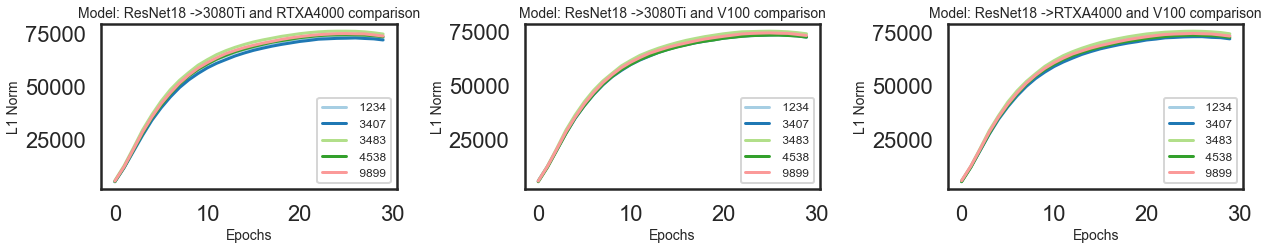

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 4)

for i in range(3):
    for j, (key, values) in enumerate(natsorted(l1_norm_dict.items())[i*5:(i+1)*5]):
        title = 'Model: ResNet18 ->' + key.split(':')[1].split(' ')[1] + ' and ' + key.split(':')[2].split(' ')[1] + ' comparison'
        seed_value = key.split(':')[-1]
        
        ax[i].plot(values, label=seed_value)
        
        ax[i].set_xlabel('Epochs', fontsize=14)
        ax[i].set_ylabel('L1 Norm', fontsize=14)
        
        ax[i].set_title(title, fontsize=14)
        ax[i].legend(fontsize=12)
    fig.tight_layout()
    plt.savefig('L1_parameters.png')
    

In [9]:
t_device = torch.device('mps')
final_ckpt_root = './final_ckpts'


In [16]:
class_wise_loss = {}

for device in device_list:
    class_wise_loss =  {0 : 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    for seed in seed_list:
        model_ckpt = f'{final_ckpt_root}/{device}/test_all_stuff_{seed}/models/final/final_seed_{seed}.pt'
        model_final = torchvision.models.resnet18(pretrained=False)
        model_final.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        model_final.maxpool = nn.Identity()
        model_final.fc = nn.Linear(model_final.fc.in_features, 10)
        model_final.load_state_dict(torch.load(model_ckpt, map_location='cpu'))
        model_final.to(t_device)

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=False, num_workers=2)
        criterion = nn.CrossEntropyLoss()
        start_time = time.time()
        model_final.eval()
        with torch.no_grad():
            for im, labels in tqdm.tqdm(test_dataloader):
                im, labels = im.to(t_device), labels.to(t_device)
                outputs = model_final(im)
                loss = criterion(outputs, labels)
                for i in range(labels.size(0)):
                    class_wise_loss[labels[i].item()] += loss.item()
        end_time =  time.time()
    for l in class_wise_loss.keys():
        class_wise_loss[l] /= 5000 
    
    print(f'Device: {device}, {class_wise_loss}, took {end_time - start_time} s')
            

Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:18<00:00,  4.33it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


Device: 3080Ti, {0: 0.3063680470407009, 1: 0.31176702051311733, 2: 0.31458641069084403, 3: 0.31337296256572006, 4: 0.3060725756496191, 5: 0.30761112797409296, 6: 0.3103314529955387, 7: 0.30851204826682804, 8: 0.30991882801502946, 9: 0.3081438005566597}, took 18.080772876739502 s
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


Device: RTXA4000, {0: 0.3185164978519082, 1: 0.3223171380445361, 2: 0.3237729703322053, 3: 0.3243358682751656, 4: 0.3182299331843853, 5: 0.3193001597762108, 6: 0.3229515107125044, 7: 0.31837055062800645, 8: 0.32006982607245443, 9: 0.3183643262028694}, took 18.101354122161865 s
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/harsha/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 79/79 [00:18<00:00,  4.29it/s]

Device: V100, {0: 0.3028922244131565, 1: 0.30857524088472127, 2: 0.3092466177687049, 3: 0.30963887767642734, 4: 0.30458491882532834, 5: 0.3063996796399355, 6: 0.3073408059477806, 7: 0.3051420320674777, 8: 0.3058677211612463, 9: 0.3042309881940484}, took 18.41710591316223 s


(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_epochs', ylabel='train_loss, test_loss'>)

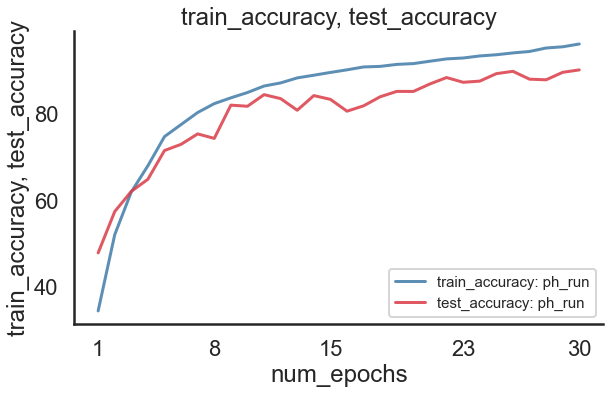

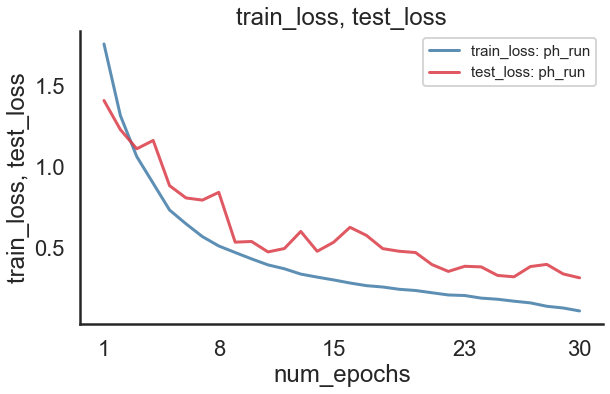

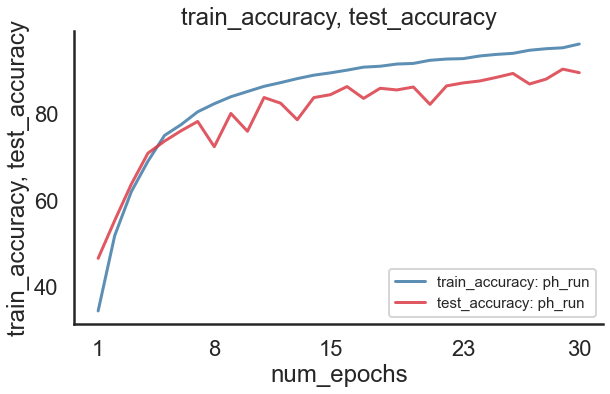

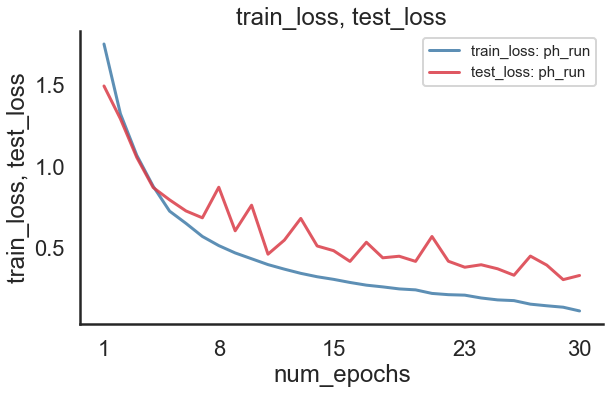

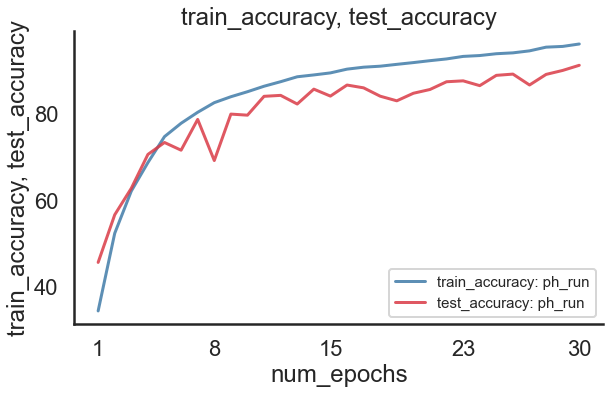

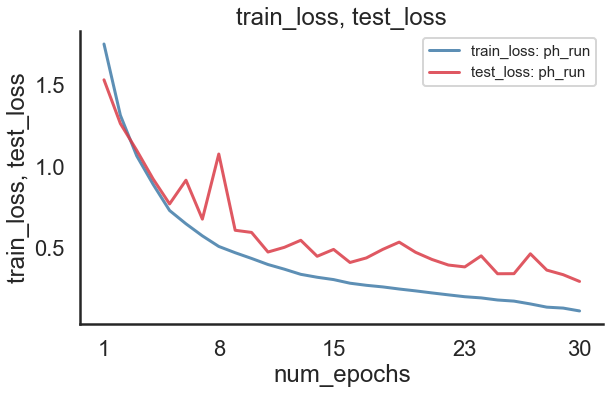

In [24]:
from mle_logging import load_log

log = load_log('./final_ckpts/3080Ti/test_all_stuff_1234/')
log1 = load_log('./final_ckpts/RTXA4000/test_all_stuff_1234/')
log2 = load_log('./final_ckpts/V100/test_all_stuff_1234/')
log.plot(['train_accuracy', 'test_accuracy'], 'num_epochs')
log.plot(['train_loss', 'test_loss'], 'num_epochs')
log1.plot(['train_accuracy', 'test_accuracy'], 'num_epochs')
log1.plot(['train_loss', 'test_loss'], 'num_epochs')
log2.plot(['train_accuracy', 'test_accuracy'], 'num_epochs')
log2.plot(['train_loss', 'test_loss'], 'num_epochs')